In [1]:
import numpy as np
from qclib.gates.ldmcu import Ldmcu
from qclib.gates.ldmcu_approx import LdmcuApprox
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt
from qclib.util import get_cnot_count

In [56]:
unitary = np.array([[0,1], [1,0]])
error = 1e-3

ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

num_control = 12

controls_base = QuantumRegister(num_control)
target = QuantumRegister(1)

print('Com error = %.6f, o circuito terá %d controles' %(error, base_ctrl_qubits))

Com error = 0.001000, o circuito terá 12 controles


## Circuito real

In [57]:
control_real = QuantumRegister(10)
circuit_1 = QuantumCircuit(control_real, target)
Ldmcu.ldmcu(circuit_1, unitary, control_real, target)

## Circuito approx

In [58]:
circuit_2 = QuantumCircuit(controls_base, target)
LdmcuApprox.ldmcu_approx(circuit_2, unitary, controls_base, target, error)

## Gráfico ldmcu vs Lmdcu_approx utilizando o operador X

In [60]:
def circuits(unitary, error, base_ctrl_q, max_contrl_q):

    target = QuantumRegister(1)
    real_circuit = []
    approx_circuit = []
    n_controls_approx = []
    for size in range(base_ctrl_q, max_contrl_q):
        controls_base = QuantumRegister(size)

        # faz append do numero de Cnots do circuito real.
        circuit_1 = QuantumCircuit(controls_base, target)
        Ldmcu.ldmcu(circuit_1, unitary, controls_base, target)
        ldmcut = transpile(circuit_1, basis_gates=['u', 'cx'])
        ldmcu_ops = ldmcut.count_ops()
        n_cnot_real = ldmcu_ops['cx']
        real_circuit.append(n_cnot_real)

        # faz append do numero de Cnots circuito aproximado.
        circuit_2 = QuantumCircuit(controls_base, target)
        LdmcuApprox.ldmcu_approx(circuit_2, unitary, controls_base, target, error)
        ldmcu_approxt = transpile(circuit_2, basis_gates=['u', 'cx'])
        ldmcu_approx_ops = ldmcu_approxt.count_ops()
        n_cnot_approx = ldmcu_approx_ops['cx']
        if True: #n_cnot_approx <= n_cnot_real:
            approx_circuit.append(ldmcu_approx_ops['cx'])
            #n_controls_approx.append(size)

    return real_circuit, approx_circuit #, n_controls_approx

In [61]:
unitary = np.array([[0,1], [1,0]]) #MCX
error = 10e-4
#ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

In [62]:
base_ctrl_q = base_ctrl_qubits
max_contrl_q = base_ctrl_qubits + 40
control_qubits = np.arange(base_ctrl_q, max_contrl_q)

In [63]:
cir_real_cnots, cir_approx_cnots = circuits(unitary, error, base_ctrl_q, max_contrl_q)

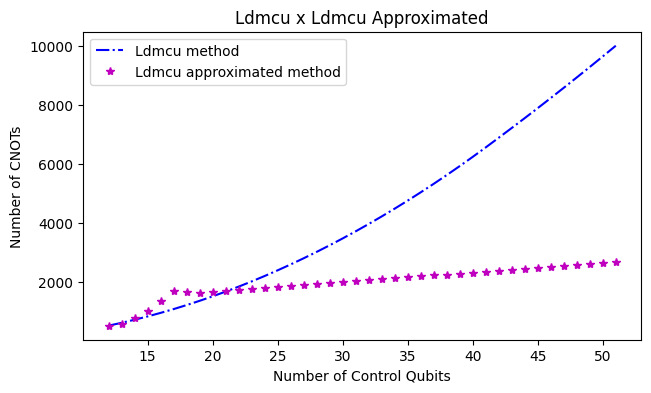

In [95]:
plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.plot(
    control_qubits, cir_real_cnots, 'b-.',
    control_qubits, cir_approx_cnots, 'm*'
)

plt.legend(
    ('Ldmcu method', 'Ldmcu approximated method'),
    loc='upper left', shadow=False
)
#plt.grid(True)
plt.title('Ldmcu x Ldmcu Approximated')
plt.xlabel('Number of Control Qubits')
plt.ylabel('Number of CNOTs')
plt.savefig("ldmcu_approx.svg", dpi=600, bbox_inches='tight')
plt.show()

## Comparação mxc

In [97]:
u = np.array([[0,1], [1,0]])
error=1e-3
ldmcu_approx_dummy = LdmcuApprox(u, num_controls=100, error=error)
base_ctrl_qubits_mcx = ldmcu_approx_dummy._get_num_base_ctrl_qubits(u,error)
print(base_ctrl_qubits_mcx)

12


In [98]:
cnot_approx=[]
cnot_original = []
base_limit = base_ctrl_qubits_mcx+25
for n_controls in range(base_ctrl_qubits_mcx, base_limit):

    controls = QuantumRegister(n_controls)
    target = QuantumRegister(1)
    circuit_approx = QuantumCircuit(controls, target)
    LdmcuApprox.ldmcu_approx(circuit_approx, u, controls, target, error)

    cnot_approx.append(get_cnot_count(circ=circuit_approx))
    circuit_og = QuantumCircuit(controls, target)
    Ldmcu.ldmcu(circuit_og, u, controls, target)
    cnot_original.append(get_cnot_count(circ=circuit_og))

print(get_cnot_count(circ=circuit_og))
print(get_cnot_count(circ=circuit_approx))

5042
2196


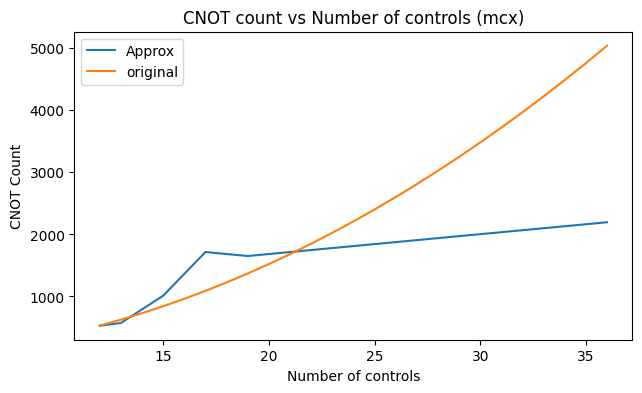

In [99]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
# Plot the data as a line plot
plt.plot(eixo_x, cnot_approx, label = "Approx")
plt.plot(eixo_x, cnot_original, label = "original")
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')

# Display the graph
plt.legend()
plt.show()

## Comparação analítica

In [100]:
def custo_og(eta, m):
    return 4*(eta+m)**2 -12*(eta+m)+10

def custo_approx(eta,m):
    return 4*(eta-2)**2 + 2*(eta-2) * (16*m-8)

def custo_otimizado(eta, m):
    return 4*(eta-2)**2 + 64*eta - 304 + 32*(eta + m)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


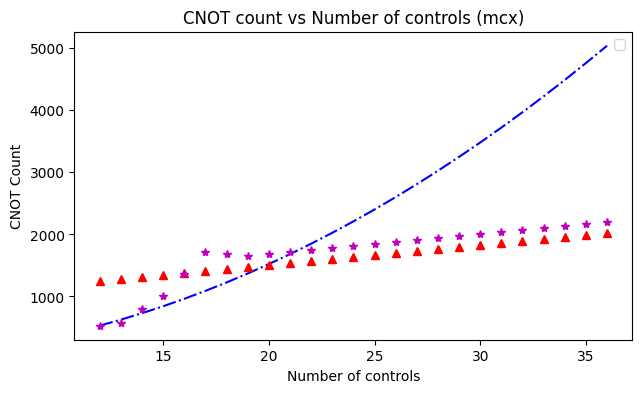

In [101]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
n_base = base_ctrl_qubits_mcx
analitico_otimizado_z_plot = [custo_otimizado(n_base, xi - n_base) for xi in eixo_x]
# Plot the data as a line plot
plt.rcParams["figure.figsize"] = (7.2, 4.0)

plt.plot(eixo_x, cnot_original, 'b-.')
plt.plot(eixo_x, analitico_otimizado_z_plot, 'r^')
plt.plot(eixo_x, cnot_approx, 'm*')
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

plt.legend(
    ('original method', 'Approximated method', 'theorem 3'),
    loc='upper left', shadow=False
)

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')
plt.savefig('comparacao_analito_numerico.svg', dpi=600, bbox_inches='tight')
# Display the graph
plt.legend()
plt.show()